Cargamos las tablas de validación desde el github. Estas contienen track_features y playlists de las 50 playlists con más canciones del dataset de 2000 playlists. Ya se encuentran limpiadas (ambas tablas sólo contienen info de canciones de menos de 15 minutos y sin valores nulos).

In [2]:
import pandas as pd

playlists_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_playlists_validation.csv')
tracks_val = pd.read_csv('https://github.com/alcazar90/CC5205-3-proyecto/raw/main/data/validacion/50_tracks_validation.csv')
cols=tracks_val.columns
tracks_val.columns=[col[15:] if col[:15]=="audio_features." else col for col in cols]
tracks_val

,Unnamed: 0,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,0,spotify:track:3RCT90rX7F5rSwMwUU4Pz6,0.616,0.850,5,-5.419,0,0.0580,0.00216,0.066700,0.1810,0.470,142.841,audio_features,3RCT90rX7F5rSwMwUU4Pz6,https://api.spotify.com/v1/tracks/3RCT90rX7F5r...,https://api.spotify.com/v1/audio-analysis/3RCT...,219560,4
1,1,spotify:track:2t5GyUfFoZg3E8ak3i7dVP,0.301,0.353,4,-15.588,0,0.0467,0.77800,0.489000,0.4060,0.189,134.588,audio_features,2t5GyUfFoZg3E8ak3i7dVP,https://api.spotify.com/v1/tracks/2t5GyUfFoZg3...,https://api.spotify.com/v1/audio-analysis/2t5G...,621107,3
2,2,spotify:track:4paJ10JPNCyOaLtz2cY928,0.801,0.548,11,-5.482,0,0.0516,0.08540,0.000232,0.3870,0.627,92.059,audio_features,4paJ10JPNCyOaLtz2cY928,https://api.spotify.com/v1/tracks/4paJ10JPNCyO...,https://api.spotify.com/v1/audio-analysis/4paJ...,188086,4
3,3,spotify:track:7qc9PaK7JeTgMkLwaXgW0q,0.308,0.948,0,-2.771,0,0.0772,0.00001,0.000022,0.1050,0.229,163.938,audio_features,7qc9PaK7JeTgMkLwaXgW0q,https://api.spotify.com/v1/tracks/7qc9PaK7JeTg...,https://api.spotify.com/v1/audio-analysis/7qc9...,228213,4
4,4,spotify:track:69d54YOS8TOQiUYjX57XeA,0.590,0.805,0,-6.481,1,0.0371,0.13700,0.000000,0.0996,0.797,138.514,audio_features,69d54YOS8TOQiUYjX57XeA,https://api.spotify.com/v1/tracks/69d54YOS8TOQ...,https://api.spotify.com/v1/audio-analysis/69d5...,154200,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9281,9290,spotify:track:1Dg4dFJr3HW7sbA7vPejre,0.652,0.583,9,-7.811,1,0.0380,0.41200,0.000000,0.1190,0.744,138.134,audio_features,1Dg4dFJr3HW7sbA7vPejre,https://api.spotify.com/v1/tracks/1Dg4dFJr3HW7...,https://api.spotify.com/v1/audio-analysis/1Dg4...,163600,4
9282,9291,spotify:track:1gV0hgMNdpSWeW7ZjSUKnX,0.740,0.831,1,-3.828,1,0.0423,0.08900,0.000000,0.0837,0.357,91.026,audio_features,1gV0hgMNdpSWeW7ZjSUKnX,https://api.spotify.com/v1/tracks/1gV0hgMNdpSW...,https://api.spotify.com/v1/audio-analysis/1gV0...,275604,4
9283,9292,spotify:track:6fkuajLhhkanfP4muJJ7nw,0.671,0.629,1,-6.992,1,0.4580,0.11700,0.000000,0.1120,0.463,176.074,audio_features,6fkuajLhhkanfP4muJJ7nw,https://api.spotify.com/v1/tracks/6fkuajLhhkan...,https://api.spotify.com/v1/audio-analysis/6fku...,174568,4
9284,9293,spotify:track:3cuGpP8vUSC1aq8tjD3J2c,0.399,0.203,4,-11.649,1,0.0298,0.66000,0.000163,0.2700,0.405,134.202,audio_features,3cuGpP8vUSC1aq8tjD3J2c,https://api.spotify.com/v1/tracks/3cuGpP8vUSC1...,https://api.spotify.com/v1/audio-analysis/3cuG...,72080,4


var_names para obtener los features que nos sirven y tracks_info para obtener información de una canción dada una uri

In [3]:
var_names=["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

tracks_info = playlists_val.drop_duplicates(subset=["track_uri"]).set_index("track_uri")[["track_name", "artist_name"]].loc[tracks_val["uri"]]

Definir clases para cada recomendador y así poder evaluarlos. Colocarlas en el espacio y formato dados.

In [7]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

class recommender_2:
    def __init__(self):
        pass
    def train(self, tracks_df, playlists_df):
        self.tracks_df, self.playlists_df = tracks_df, playlists_df
        playlist_ids=list(set(playlists_df["pid"]))
        self.X_ori=np.asarray(tracks_df[var_names])
        self.X=(self.X_ori-np.tile(np.mean(self.X_ori, axis=0), (self.X_ori.shape[0], 1)))/np.tile(np.std(self.X_ori, axis=0), (self.X_ori.shape[0], 1))
        self.X_t=PolynomialFeatures(1).fit_transform(self.X)
        self.W=np.zeros(0)
        total=len(playlist_ids)
        self.lists=np.zeros(shape=(len(self.X), total))-1
        for playlist_i in range(total):
            print(playlist_i) if (playlist_i % (total/5))==0 else None
            this_playlist=playlists_df[playlists_df["pid"]==playlist_ids[playlist_i]]
            y=1*tracks_df["uri"].isin(this_playlist["track_uri"])
            if(sum(y))>0:
                self.lists[y==1, playlist_i]=playlist_i
                clf=LogisticRegression(fit_intercept=False)
                clf.fit(self.X_t, y)
                self.W=np.append(self.W, clf.coef_)
        self.lists=np.asarray(self.lists)
        self.W=self.W.reshape(-1, clf.coef_.size)
        ret=np.exp(self.X_t @ self.W.T-10)
        self.probas=ret/np.tile(np.apply_along_axis(sum, 1, ret), (self.W.T.shape[1],1)).T
    def recommend_list(self, canciones_df, suavizado=1000, number=100, exclude_same=True):
        canciones=np.asarray(canciones_df[var_names])
        canciones=np.asarray(canciones).reshape(-1, 13)
        canciones=(canciones-np.tile(np.mean(self.X_ori, axis=0), (canciones.shape[0], 1)))/np.tile(np.std(self.X_ori, axis=0), (canciones.shape[0], 1))
        canciones_t=PolynomialFeatures(1).fit_transform(canciones)
        matmult=np.exp(canciones_t @ self.W.T-10)
        probas_canciones=matmult/np.tile(np.apply_along_axis(sum, 1, matmult), (self.W.T.shape[1],1)).T
        puntajes=np.zeros(len(self.X))
        not_in_input=np.ones(len(self.X))
        for this_proba in probas_canciones:
            distancia_proba=np.asarray([np.linalg.norm(this_proba-proba) for proba in self.probas])
            not_in_input=not_in_input*(distancia_proba>1e-15)*1 if exclude_same else not_in_input
            order=np.argsort(np.argsort(distancia_proba))
            puntajes+=np.exp(-order*len(canciones)/suavizado)
        puntajes=puntajes*not_in_input if exclude_same else puntajes
        final_order=np.argsort(-puntajes)
        y_recom=np.zeros(len(self.X))
        y_recom[final_order[:number]]=1
        return self.tracks_df.iloc[final_order][:number]["uri"]

#Colocar acá las clases de sus clasificadores.
#Pueden o no tener init o train, pero deben tener una función recommend_list
class recommender_x:
    def __init__(self):
        pass
    #Puede no tener train, dependiendo de cómo funcione. Pero debe utilizar las canciones dentro del dataset de validación.
    def train(self, tracks_df, playlists_df):
        pass
    #Esta función DEBE tomar como input un dataframe de canciones.
    #Debe tambien tomar el argumento "number" para setear el número de recomendaciones
    def recommend_list(self, canciones_df, number=100, **kwargs):
        #DEBE retornar una lista de uris de las canciones output 
        return None

recomendador_2=recommender_2()
recomendador_2.train(tracks_val, playlists_val)

0
10
20
30
40


Calculamos la métrica en los datos de validación. Para una lista dada, se eligen aleatoreamente 20 canciones que pertenezcan a la lista y se obtienen N-20 recomendaciones, donde N es la cantidad de canciones de la lista (las listas del dataset de validación tienen entre 210-375 canciones). Luego, evalúa qué porcentaje de las N-20 canciones output pertenecen a la lista original. Repite este proceso. Se grafica el histograma de desempeño del recomendador.

5 de 50
10 de 50
15 de 50
20 de 50
25 de 50
30 de 50
35 de 50
40 de 50
45 de 50
50 de 50
Eficiencia recomendador 2: 14.82255575531915 %


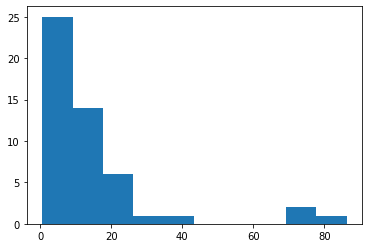

In [8]:
import matplotlib.pyplot as plt

np.random.seed(1991)

def validar_lista(pid, recomendador):
    input_uris= list(set(playlists_val[playlists_val["pid"]==pid]["track_uri"]))
    input_df=tracks_val.set_index("uri").loc[np.random.choice(input_uris, 20)]
    output_uris= recomendador.recommend_list(input_df, number=len(input_uris)-20)
    output_pid= playlists_val.set_index("track_uri").loc[output_uris]["pid"]
    return sum(output_pid==pid)*100.0/(len(input_uris)-20)

def validar_recomendador(recomendador):
    porcentajes=[]
    for i, pid in enumerate(list(set(playlists_val["pid"]))):
        porcentajes.append(validar_lista(pid, recomendador))
        print(i+1,"de", len(set(playlists_val["pid"]))) if (i+1)%5==0 else None
    plt.hist(porcentajes)
    return np.mean(porcentajes)
    
eficiencia_2=validar_recomendador(recomendador_2)

print("Eficiencia recomendador 2:", eficiencia_2,"%")

#eficiencia_x=validar_recomendador(recomendador_x)

#print("Eficiencia recomendador x:", eficiencia_x,"%")